In [1]:
import numpy as np
import numpy.linalg as la
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
from tqdm import tqdm_notebook as tqdm

from data import cities, prime_cities, prime_set
from metrics import metric

from random import sample, choice
from scipy.spatial import cKDTree as KDTree
from concorde.tsp import TSPSolver
from multiprocessing import Pool, cpu_count
from pathlib import Path

In [2]:
jtplot.style(figsize=(24, 15))
N = len(cities)
SAVED_CONCORDE_PATH = Path("concorde.path")

[]

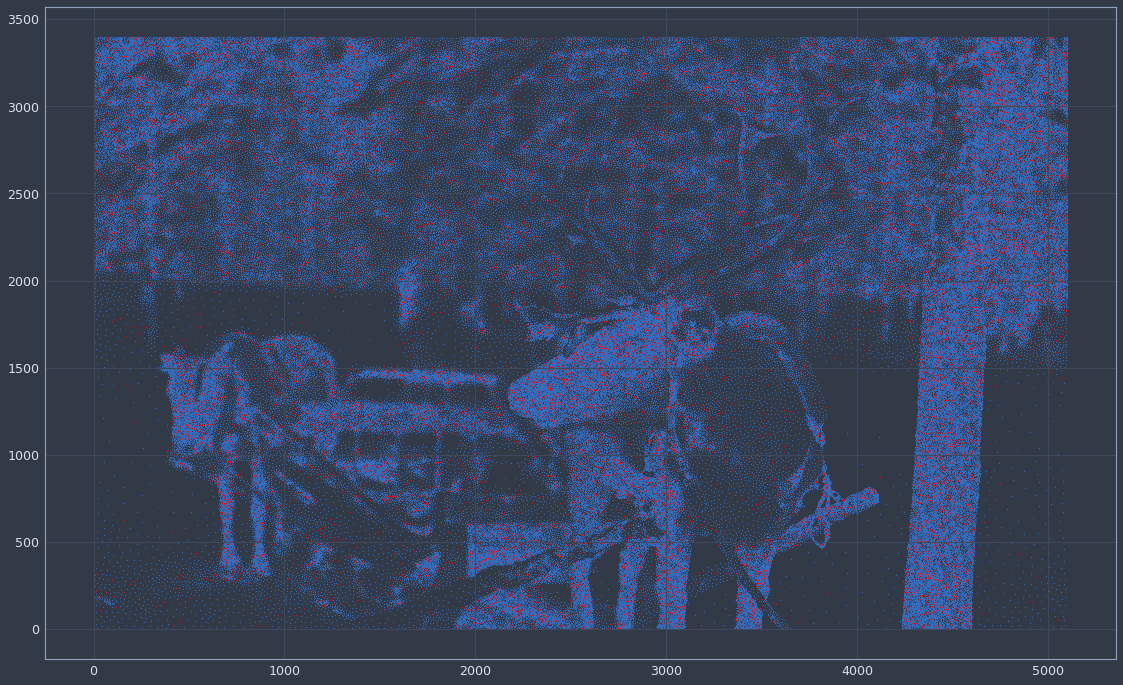

In [3]:
plt.scatter(cities[:,0], cities[:,1], s=1)
plt.scatter(cities[prime_cities,0], cities[prime_cities,1], s=1, c="red")
plt.plot()

In [4]:
solver = TSPSolver.from_data(
    (cities[:, 0]*1000).astype(np.int32),
    (cities[:, 1]*1000).astype(np.int32),
    norm="EUC_2D"
)

In [5]:
%%time
if not SAVED_CONCORDE_PATH.exists():
    tour_data = solver.solve(time_bound = 60.0, verbose = True, random_seed = 42) # solve() doesn't seem to respect time_bound for certain values?
    path = tour_data.tour
    with SAVED_CONCORDE_PATH.open("w") as f:                      # at least we can serialize the results
        f.write(" ".join(map(str, path)))
else:
    with SAVED_CONCORDE_PATH.open("r") as f:
        line = f.read()
        path = list(
                    map(
                        int, 
                        line.split()
                    )
                )

CPU times: user 39.4 ms, sys: 3.85 ms, total: 43.2 ms
Wall time: 42.4 ms


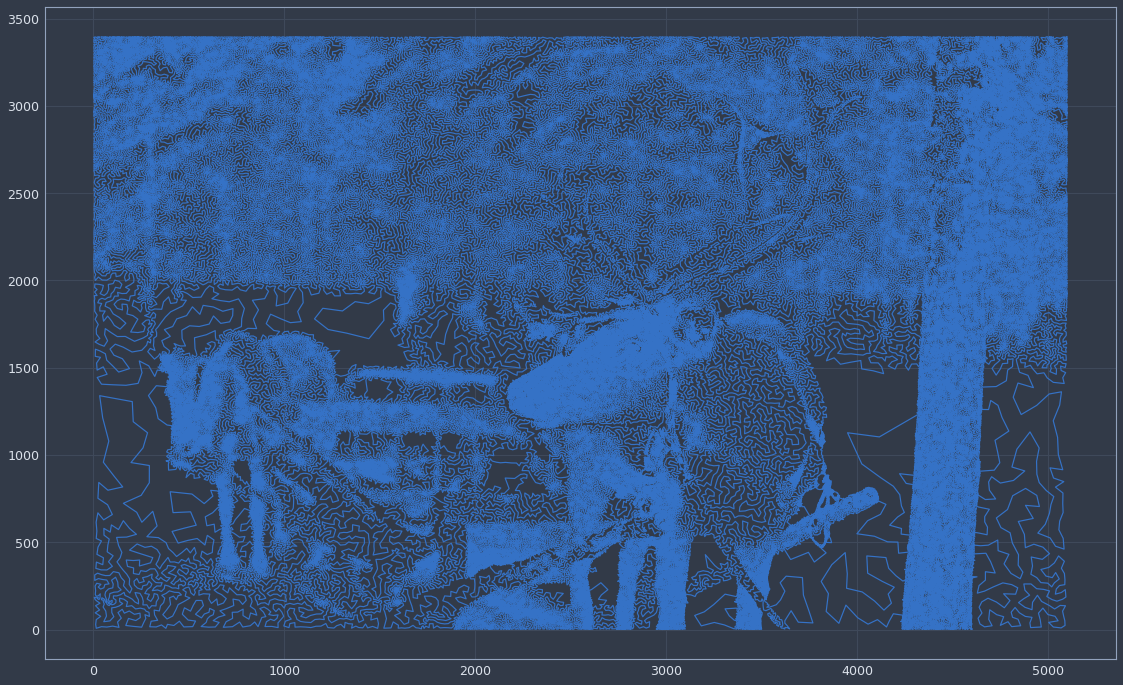

In [6]:
plt.plot(cities[path][:, 0], cities[path][:, 1])
plt.show()

In [7]:
kdt = KDTree(cities[prime_cities])
lookup_tbl = {tuple(prime): i for i, prime in enumerate(cities[prime_cities])}

In [8]:
best = metric(path)
path = np.array(path)
for fuel_stop in tqdm(range(9, len(path)-1, 10)):
    new_path = path.copy()
    _, near_prime_city = kdt.query(cities[fuel_stop])
    j = np.nonzero(new_path == near_prime_city)
    new_path[fuel_stop], new_path[j] = new_path[j], new_path[fuel_stop]
    new_metric = metric(new_path)
    if best > new_metric:
        print(f"Made swap that improved metric from {best} to {new_metric}")
        path, best = new_path, new_metric
        

In [9]:
metric(path)

1524707.7790094533

In [10]:
?KDTree